# Attempting to load ASPECT

An initial attempt at loading higher order element output from ASPECT. 

The VTU files have elements with a VTU type of `VTK_LAGRANGE_HEXAHEDRON` (VTK ID number 72, https://vtk.org/doc/nightly/html/classvtkLagrangeHexahedron.html#details). 

Some useful links about this type of FEM output:
* https://blog.kitware.com/modeling-arbitrary-order-lagrange-finite-elements-in-the-visualization-toolkit/
* https://github.com/Kitware/VTK/blob/0ce0d74e67927fd964a27c045d68e2f32b5f65f7/Common/DataModel/vtkCellType.h#L112
* https://github.com/ju-kreber/paraview-scripts
* https://doi.org/10.1016/B978-1-85617-633-0.00006-X

At present, tis notebook requires the `vtu72` branch on the `meshio` fork at https://github.com/chrishavlin/meshio/pull/new/vtu72 to attempt to load the `VTK_LAGRANGE_HEXAHEDRON` output. 

As seen below, the data can be loaded with the general `unstructured_mesh_loader` but `yt` can not presently handle higher order output. 


In [6]:
import os, yt, numpy as np
import xmltodict, meshio 

In [7]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','../'),'litho_defo_sample','data')

In [8]:
pFile=os.path.join(DataDir,'solution-00002.pvtu')
if os.path.isfile(pFile) is False:
    print("data file not found")

In [9]:
class pvuFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']        
            
    def load(self):                      
    
        conlist=[]  # list of 2D connectivity arrays 
        coordlist=[] # global, concatenated coordinate array 
        nodeDictList=[] # list of node_data dicts, same length as conlist 

        con_offset=-1
        for mesh_id,src in enumerate(self.pXML['VTKFile']['PUnstructuredGrid']['Piece']):    
            mesh_name="connect{meshnum}".format(meshnum=mesh_id+1) # connect1, connect2, etc.            
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
            con_offset=con.max() 
            
            conlist.append(con.astype("i8"))
            coordlist.extend(coord.astype("f8"))
            nodeDictList.append(node_d)
            
        self.connectivity=conlist
        self.coordinates=np.array(coordlist)
        self.node_data=nodeDictList
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 
#         print(srcFi)
        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        connectivity=meshPiece.cells_dict['lagrange_hexahedron'] # 2D connectivity array 

        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name)

        # offset the connectivity matrix to global value 
        connectivity=np.array(connectivity)+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}
        def rshpData(data1d):
            return np.reshape(data1d[con1d],conn_shp)
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=rshpData(point_data[nm][:,component])
                else:
                    # just a scalar! 
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=rshpData(point_data[nm])
    
        return node_data      


In [10]:
pvuData=pvuFile(pFile)
pvuData.load()

So it loads... `meshio`'s treatment of high order elements is not complicated: it assumes the same number of nodes per elements and just reshapes the 1d connectivity array appropriately. In this case, a single element has 27 nodes:

In [14]:
pvuData.connectivity[0].shape

(581, 27)

And yes, it can load:

In [15]:
ds4 = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data
)  

yt : [INFO     ] 2020-08-03 15:31:05,801 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-08-03 15:31:05,802 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-08-03 15:31:05,802 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-08-03 15:31:05,803 Parameters: domain_right_edge         = [88000.   550. 33000.]
yt : [INFO     ] 2020-08-03 15:31:05,803 Parameters: cosmological_simulation   = 0.0


but the plots are garbled, presumably because "High order elements not yet supported, dropping to 1st order."

yt : [INFO     ] 2020-08-03 15:31:18,713 xlim = 0.000000 88000.000000
yt : [INFO     ] 2020-08-03 15:31:18,716 ylim = 0.000000 550.000000
yt : [INFO     ] 2020-08-03 15:31:18,718 xlim = 0.000000 88000.000000
yt : [INFO     ] 2020-08-03 15:31:18,720 ylim = 0.000000 550.000000
yt : [INFO     ] 2020-08-03 15:31:18,732 Making a fixed resolution buffer of (('all', 'T')) 800 by 800
yt : [WARNING  ] 2020-08-03 15:31:18,750 High order elements not yet supported, dropping to 1st order.



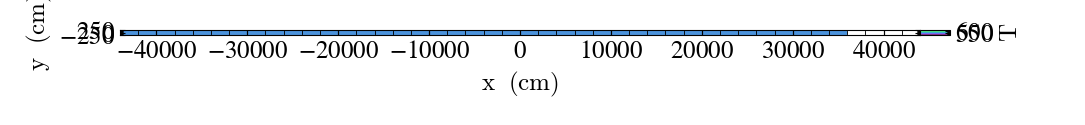

In [16]:
p=yt.SlicePlot(ds4, "z", ("all", "T"))
p.set_log("T",False)
p.show()

This run is a very high aspect ratio cartesian simulation:

In [18]:
def minmax(x):
    return [x.min(),x.max()]

for idim in range(0,3):
    print([idim,minmax(pvuData.coordinates[:,idim])])

[0, [0.0, 80000.0]]
[1, [0.0, 500.0]]
[2, [0.0, 30000.0]]


So let's rescale the coords first and then reload

In [19]:
# some artificial rescaling 
for idim in range(0,3):
    pvuData.coordinates[:,idim]=pvuData.coordinates[:,idim] / pvuData.coordinates[:,idim].max()


In [20]:
ds4 = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data
)  

yt : [INFO     ] 2020-08-03 15:33:32,270 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-08-03 15:33:32,271 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-08-03 15:33:32,272 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-08-03 15:33:32,272 Parameters: domain_right_edge         = [1.1 1.1 1.1]
yt : [INFO     ] 2020-08-03 15:33:32,273 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2020-08-03 15:33:35,419 xlim = 0.000000 1.100000
yt : [INFO     ] 2020-08-03 15:33:35,420 ylim = 0.000000 1.100000
yt : [INFO     ] 2020-08-03 15:33:35,423 xlim = 0.000000 1.100000
yt : [INFO     ] 2020-08-03 15:33:35,424 ylim = 0.000000 1.100000
yt : [INFO     ] 2020-08-03 15:33:35,425 Making a fixed resolution buffer of (('all', 'T')) 800 by 800
yt : [WARNING  ] 2020-08-03 15:33:35,446 High order elements not yet supported, dropping to 1st order.



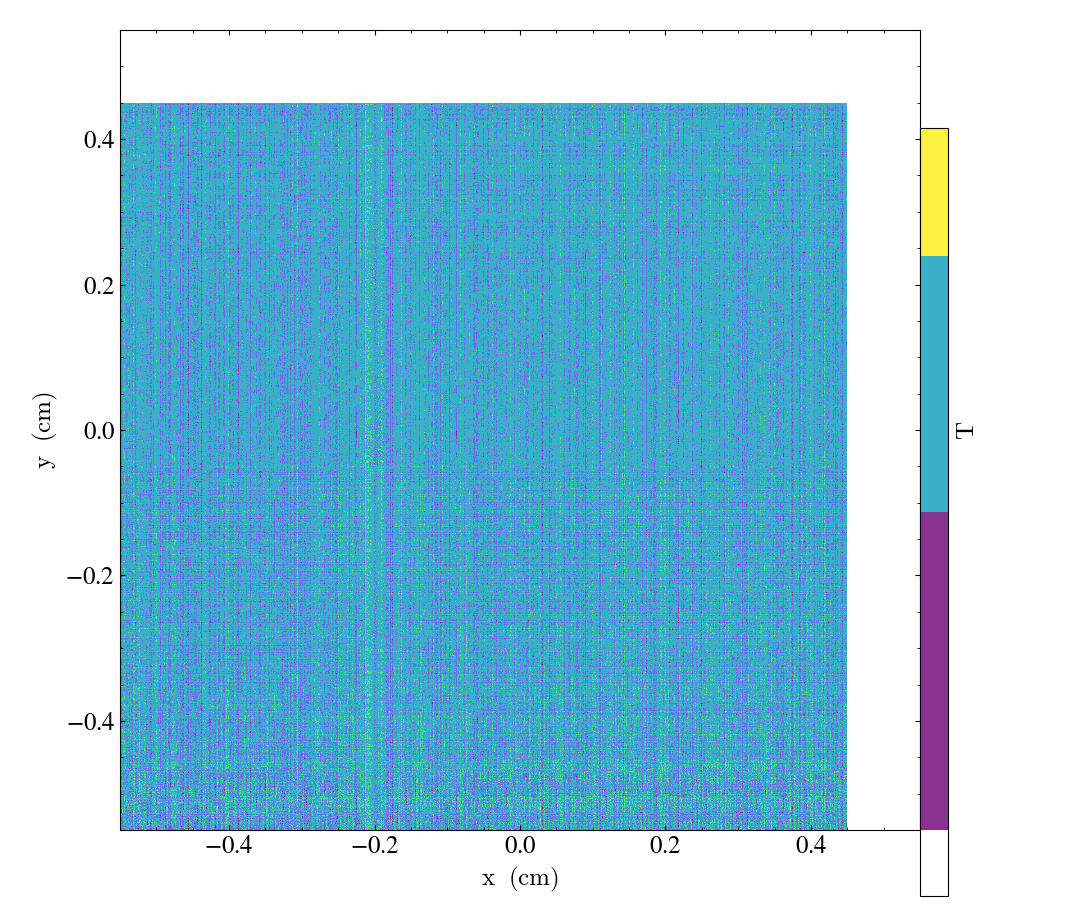

In [21]:
p=yt.SlicePlot(ds4, "z", ("all", "T"))
p.set_log("T",False)
p.show()

before looking into `yt`, let's see if we can just extract the lower order data at the element vertices (or the face-centered cell edges since there are 12). 

In [ ]:
class pvuFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']        
            
    def load(self):                      
    
        conlist=[]  # list of 2D connectivity arrays 
        coordlist=[] # global, concatenated coordinate array 
        nodeDictList=[] # list of node_data dicts, same length as conlist 

        con_offset=-1
        for mesh_id,src in enumerate(self.pXML['VTKFile']['PUnstructuredGrid']['Piece']):    
            mesh_name="connect{meshnum}".format(meshnum=mesh_id+1) # connect1, connect2, etc.            
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
            con_offset=con.max() 
            
            conlist.append(con.astype("i8"))
            coordlist.extend(coord.astype("f8"))
            nodeDictList.append(node_d)
            
        self.connectivity=conlist
        self.coordinates=np.array(coordlist)
        self.node_data=nodeDictList
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 
#         print(srcFi)
        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        connectivity=meshPiece.cells_dict['lagrange_hexahedron'] # 2D connectivity array 
        
        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name)

        # offset the connectivity matrix to global value 
        connectivity=np.array(connectivity)+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}
        def rshpData(data1d):
            return np.reshape(data1d[con1d],conn_shp)
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=rshpData(point_data[nm][:,component])
                else:
                    # just a scalar! 
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=rshpData(point_data[nm])
    
        return node_data      
